# Melanoma analysis with convolutional neural networks

This notebook shows how good are [convolutional neural networks](#Convolutional-neural-networks) for [melanoma](#Melanoma) analysis.

In [1]:
import datetime
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

Check if a GPU is available.

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Melanoma

__Melanoma__, also redundantly known as __malignant melanoma__, is a type of skin cancer that develops from the pigment-producing cells known as melanocytes. Melanomas typically occur in the skin, but may rarely occur in the mouth, intestines, or eye (uveal melanoma). In women, they most commonly occur on the legs, while in men, they most commonly occur on the back. About 25% of melanomas develop from moles. Changes in a mole that can indicate melanoma include an increase in size, irregular edges, change in color, itchiness, or skin breakdown.

![melanoma image](../assets/melanoma.jpg)

<div style="text-align: center; font-weight: bold">Pic.1. A melanoma of approximately 2.5 cm (1 in) by 1.5 cm (0.6 in)</div>

The primary cause of melanoma is ultraviolet light (UV) exposure in those with low levels of the skin pigment melanin. The UV light may be from the sun or other sources, such as tanning devices. Those with many moles, a history of affected family members, and poor immune function are at greater risk. A number of rare genetic conditions, such as xeroderma pigmentosum, also increase the risk. Diagnosis is by biopsy and analysis of any skin lesion that has signs of being potentially cancerous.

Melanoma is the most dangerous type of skin cancer. Globally, in 2012, it newly occurred in 232,000 people. In 2015, 3.1 million people had active disease, which resulted in 59,800 deaths. Australia and New Zealand have the highest rates of melanoma in the world. High rates also occur in Northern Europe and North America, while it is less common in Asia, Africa, and Latin America. In the United States, melanoma occurs about 1.6 times more often in men than women. Melanoma has become more common since the 1960s in areas mostly populated by people of European descent.

# Convolutional neural networks

In deep learning, a __convolutional neural network__ (CNN, or ConvNet) is a class of artificial neural network, most commonly applied to analyze visual imagery.They are also known as shift invariant or space invariant artificial neural networks (SIANN), based on the shared-weight architecture of the convolution kernels or filters that slide along input features and provide translation equivariant responses known as feature maps. Counter-intuitively, most convolutional neural networks are only equivariant, as opposed to invariant, to translation. They have applications in image and video recognition, recommender systems, image classification, image segmentation, medical image analysis, natural language processing, brain-computer interfaces, and financial time series.

![CNN image](../assets/cnn.jpeg)

<div style="text-align: center; font-weight: bold">Pic.2. Example architecture of a convolutional neural network</div>

CNNs are regularized versions of multilayer perceptrons. Multilayer perceptrons usually mean fully connected networks, that is, each neuron in one layer is connected to all neurons in the next layer. The "full connectivity" of these networks make them prone to overfitting data. Typical ways of regularization, or preventing overfitting, include: penalizing parameters during training (such as weight decay) or trimming connectivity (skipped connections, dropout, etc.) CNNs take a different approach towards regularization: they take advantage of the hierarchical pattern in data and assemble patterns of increasing complexity using smaller and simpler patterns embossed in their filters. Therefore, on a scale of connectivity and complexity, CNNs are on the lower extreme.

Convolutional networks were inspired by biological processes in that the connectivity pattern between neurons resembles the organization of the animal visual cortex. Individual cortical neurons respond to stimuli only in a restricted region of the visual field known as the receptive field. The receptive fields of different neurons partially overlap such that they cover the entire visual field.

CNNs use relatively little pre-processing compared to other image classification algorithms. This means that the network learns to optimize the filters (or kernels) through automated learning, whereas in traditional algorithms these filters are hand-engineered. This independence from prior knowledge and human intervention in feature extraction is a major advantage.

# Data loading

In [3]:
generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=180,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=(0.2, 1.5),
    validation_split=0.2,
)


training_set = generator.flow_from_directory(
    '/small-data', 
    target_size=(128, 128), 
    batch_size=32, 
    class_mode='categorical', 
    subset='training'
)
validation_set = generator.flow_from_directory(
    '/small-data', 
    target_size=(128, 128), 
    batch_size=32, 
    class_mode='categorical', 
    subset='validation'
)

Found 638 images belonging to 2 classes.
Found 159 images belonging to 2 classes.


In [4]:
CLASS_NUMBER = len(training_set.class_indices)

### Data source

As a data source, we use the ISIC Archive.

The ISIC Archive is an open source platform with publicly available images of skin lesions under Creative Commons licenses. The images are associated with ground-truth diagnoses and other clinical metadata. Images can be queried using faceted search and downloaded individually or in batches. The initial focus of the archive has been on dermoscopy images of individual skin lesions, as these images are inherently standardized by the use of a specialized acquisition device and devoid of many of the privacy challenges associated with clinical images. To date, the images have been provided by specialized melanoma centers from around the world. The archive is designed to accept contributions from new sources under the Terms of Use and welcomes new contributors. There are ongoing efforts to supplement the dermoscopy images in the archive with close-up clinical images and a broader representation of skin types. The images in the Archive are used to support educational efforts through linkage with Dermoscopedia and are used for Grand Challenges and Live Challenges to engage the computer science community for the development of diagnostic AI.

For more information, go to [ISIC Archive web site](https://www.isic-archive.com/)

# Model training

### Building the model

We build a convolutional neural network with 3 convolutional layers, 3 maxpoool layers, batch normalization and 2 dense layers.

![cnn architecture](../assets/cnn.drawio.svg)

<div style="text-align: center; font-weight: bold">Pic.3. The architecture of our convolutional neural network</div>

In [5]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(
        filters=64, 
        kernel_size=3, 
        activation='relu', 
        input_shape=(128, 128, 3)
    ),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    
    tf.keras.layers.Conv2D(
        filters=64, 
        kernel_size=3, 
        activation='relu'
    ),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    
    tf.keras.layers.Conv2D(
        filters=64, 
        kernel_size=3, 
        activation='relu'
    ),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(units=CLASS_NUMBER, activation='softmax')
])

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

In [7]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Preparing TensorFlow callbacks

For our convenience, we create a few TensorFlow callbacks.

#### The TensorBoard callback

We want to see how the training is going. We add the callback, which will log the metrics to TensorBoard.

In [8]:
log_dir = '../logs/fit/' + datetime.datetime.now().strftime('convnet')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

#### The EarlyStopping callback

This callback stops training when the metrics (e.g. validation loss) are not improving,

In [9]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.01, 
    patience=10, 
    restore_best_weights=True
)

#### The ModelCheckpoint callback

This callback saves the model with the best metrics during training.

In [10]:
checkpoint_path = 'checkpoints/convnet.ckpt'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    mode='auto'
)

### Training the model

In [11]:
model.fit(
    training_set, 
    validation_data=validation_set, 
    epochs=200, 
    callbacks=[
                tensorboard_callback,
                checkpoint_callback,
                early_stop_callback
            ]
)

Epoch 1/200
20/20 [==============================] - ETA: 0s - loss: 0.9835 - accuracy: 0.7461
Epoch 00001: val_loss improved from inf to 0.49510, saving model to checkpoints/convnet.ckpt
INFO:tensorflow:Assets written to: checkpoints/convnet.ckpt/assets
20/20 [==============================] - 39s 2s/step - loss: 0.9835 - accuracy: 0.7461 - val_loss: 0.4951 - val_accuracy: 0.8428
Epoch 2/200
20/20 [==============================] - ETA: 0s - loss: 0.5917 - accuracy: 0.7994
Epoch 00002: val_loss did not improve from 0.49510
20/20 [==============================] - 37s 2s/step - loss: 0.5917 - accuracy: 0.7994 - val_loss: 0.5007 - val_accuracy: 0.8428
Epoch 3/200
20/20 [==============================] - ETA: 0s - loss: 0.4161 - accuracy: 0.8276
Epoch 00003: val_loss improved from 0.49510 to 0.44108, saving model to checkpoints/convnet.ckpt
INFO:tensorflow:Assets written to: checkpoints/convnet.ckpt/assets
20/20 [==============================] - 38s 2s/step - loss: 0.4161 - accuracy: 0.

# Model validation

### Loading the model

We load the model with the best metrics (e.g. validation loss) from the checkpoint.

In [12]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(
        filters=64, 
        kernel_size=3, 
        activation='relu', 
        input_shape=(128, 128, 3)
    ),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    
    tf.keras.layers.Conv2D(
        filters=64, 
        kernel_size=3, 
        activation='relu'
    ),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    
    tf.keras.layers.Conv2D(
        filters=64, 
        kernel_size=3, 
        activation='relu'
    ),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(units=CLASS_NUMBER, activation='softmax')
])

In [13]:
model.load_weights('./checkpoints/convnet.ckpt')

### Loading the test data

In [14]:
testing_set = generator.flow_from_directory(
    '/small-data-test',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

Found 199 images belonging to 2 classes.


### Making diagnoses

In [15]:
true_labels = np.concatenate([testing_set[i][1] for i in range(len(testing_set))], axis=0)

In [16]:
predicted_labels = model.predict(testing_set)

### Plot the ROC Curve

In [17]:
fpr = dict()
tpr = dict()
auc_metric = dict()

diagnosis_index_dict = {v: k for k, v in testing_set.class_indices.items()}

for i in range(CLASS_NUMBER):
    diagnosis = diagnosis_index_dict[i]
    fpr[diagnosis], tpr[diagnosis], _ = roc_curve(true_labels[:, i], predicted_labels[:, i])
    auc_metric[diagnosis] = auc(fpr[diagnosis], tpr[diagnosis])

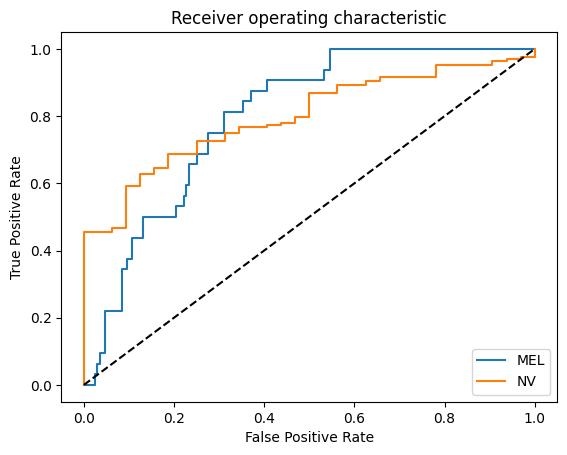

In [18]:
for diagnosis in testing_set.class_indices:
    plt.plot(fpr[diagnosis], tpr[diagnosis], label=diagnosis)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Show AUC

In [19]:
auc_metric

{'MEL': 0.7971556886227544, 'NV': 0.7971556886227544}